In [1]:
import sys
sys.path.insert(0,'/home/olgan96/.env/lib/python3.11/site-packages/')

In [2]:
from sklearn.decomposition import PCA

In [3]:
import matplotlib.pyplot as plt

/home/olgan96/.env/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
import pandas as pd

In [5]:
import seaborn as sns

In [6]:
import leidenalg as la
from sklearn.neighbors import kneighbors_graph
import igraph as ig
import umap.umap_ as umap
import numpy as np
from sklearn.preprocessing import StandardScaler

In [7]:
df = pd.read_parquet('../../NO_BACKUP/lincs_2020/signature_response_features_r2_top0.7_final.parquet')

# Expression features of all genes

## PCA

In [9]:
cols_expr = df.columns[2057:14385]

In [10]:
X = df[cols_expr].values

In [11]:
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

pca = PCA(n_components=100)
X_new_ = pca.fit_transform(X_s)

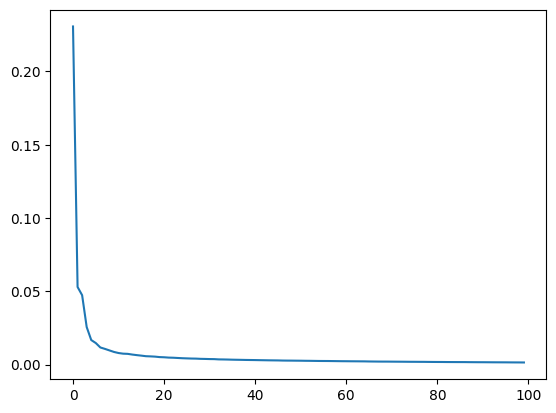

In [12]:
plt.plot(list(range(100)), pca.explained_variance_ratio_)

## Clustering

In [13]:
# This returns a sparse matrix (same idea as adata.obsp['connectivities'])
knn_graph = kneighbors_graph(X_new_, n_neighbors=20, mode='connectivity', include_self=False)

In [14]:
# Convert to igraph Graph
sources, targets = knn_graph.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))
g = ig.Graph(edges=edges, directed=False)

# Set weights if needed (optional)
g.es['weight'] = knn_graph[knn_graph.nonzero()].A1  # for weighted graphs

# Run Leiden with resolution
partition = la.find_partition(
    g,
    la.RBConfigurationVertexPartition,
    resolution_parameter=0.5,
    weights='weight'  # or None if unweighted
)

# Get cluster labels
labels = np.array(partition.membership)

In [15]:
pd.DataFrame(labels).rename(columns={0:'leiden'})#.to_parquet('../../NO_BACKUP/lincs_2020/labels.parquet', index=False)

leiden
0           0
1           0
2           0
3           2
4           0
...       ...
40504       2
40505       0
40506       3
40507       1
40508       2

[40509 rows x 1 columns]

In [35]:
df['leiden'] = labels
df['pc1'] = X_new_[:, 0]
df['pc2'] = X_new_[:, 1]

### Clusters

<Axes: xlabel='pc1', ylabel='pc2'>

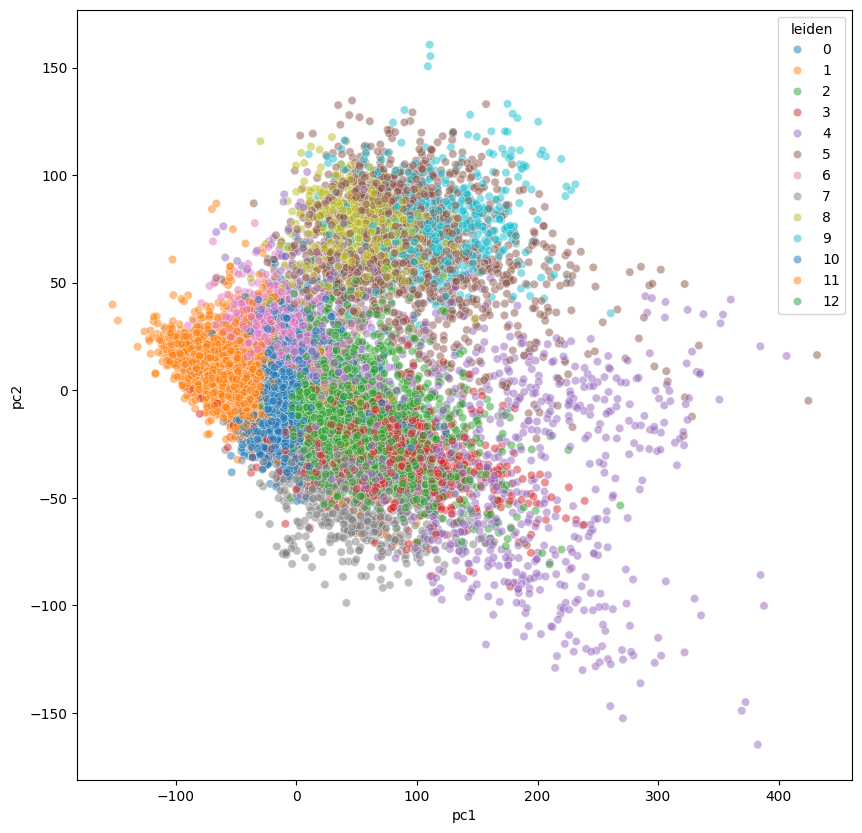

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='leiden', alpha=0.5, palette='tab10')

### Responses

<Axes: xlabel='pc1', ylabel='pc2'>

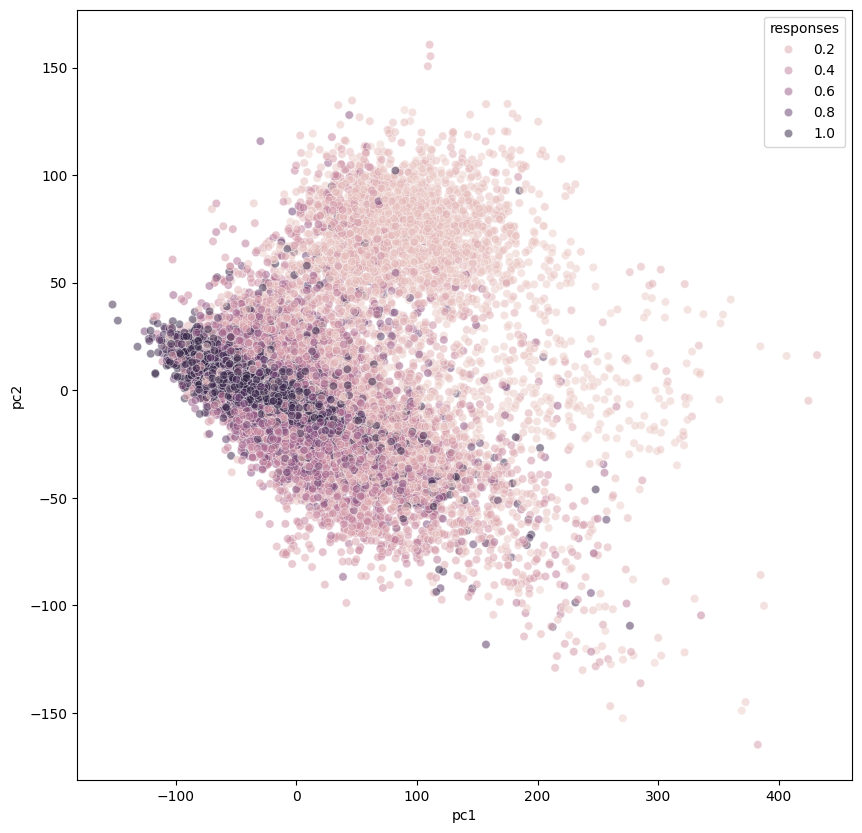

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df, x='pc1', y='pc2', hue='responses', alpha=0.5)

## UMAP

In [19]:
reducer = umap.UMAP(n_neighbors=50)
reducer.fit(X_new_)
X_new_pca_umap = reducer.transform(X_new_)

In [20]:
df_umap = pd.DataFrame(X_new_pca_umap)

In [21]:
df_umap['leiden'] = labels

In [22]:
df_umap['responses'] = df['responses']

In [23]:
df_umap = df_umap.rename(columns={0: 'v1', 1: 'v2'})

### Clusters

<Axes: xlabel='v1', ylabel='v2'>

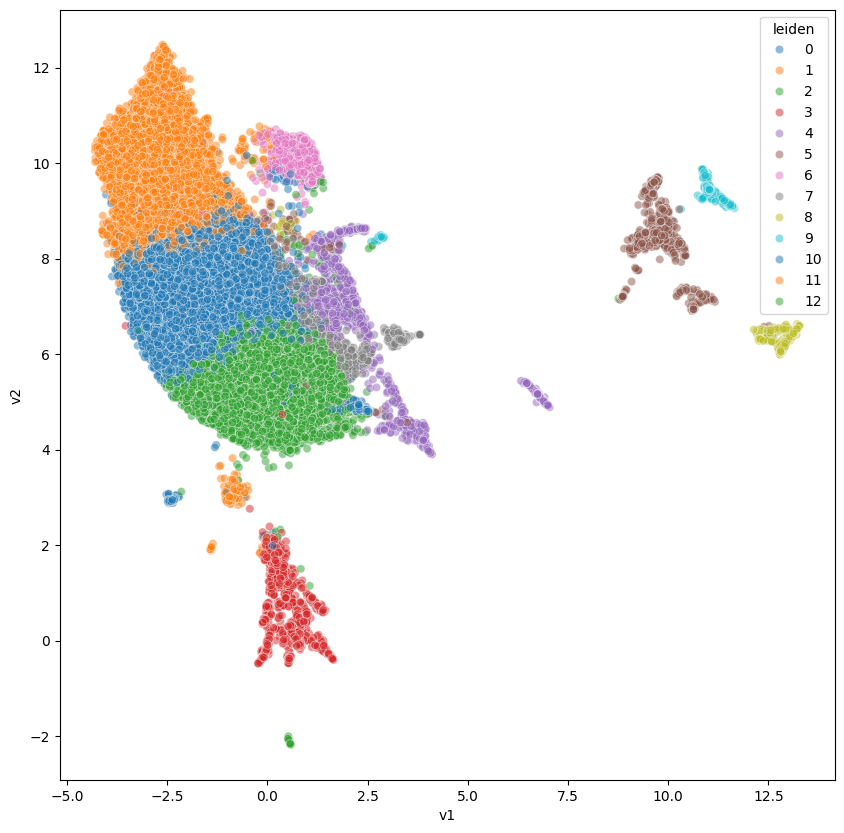

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_umap, x='v1', y='v2', hue='leiden', alpha=0.5, palette='tab10')

### Responses all

<Axes: xlabel='v1', ylabel='v2'>

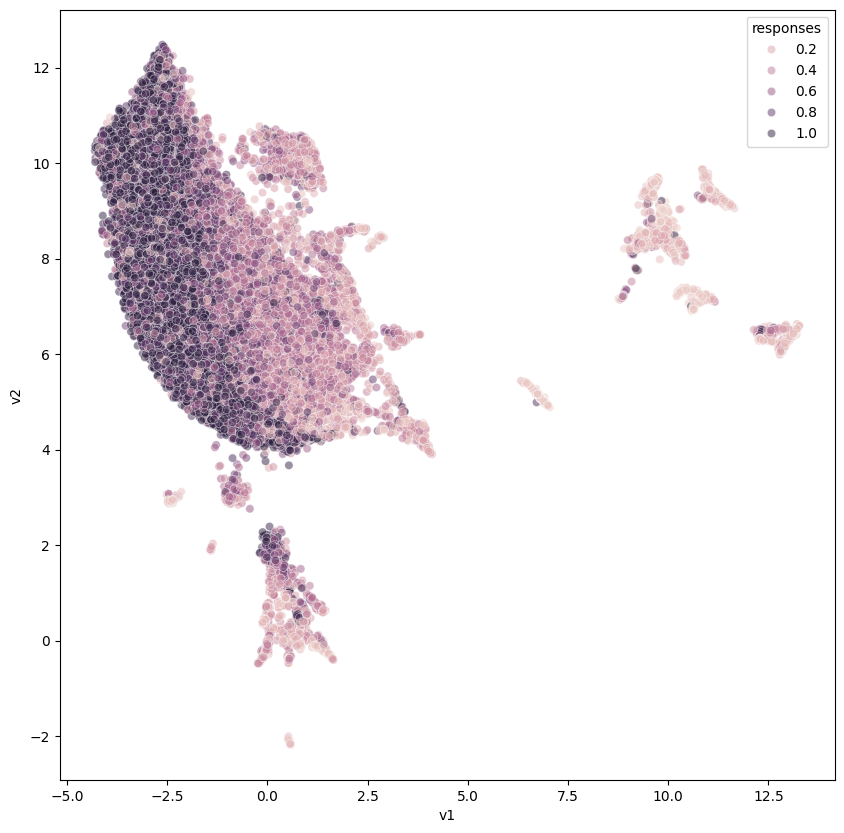

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_umap, x='v1', y='v2', hue='responses', alpha=0.5)

### Responses high viability

<Axes: title={'center': 'high viability'}, xlabel='v1', ylabel='v2'>

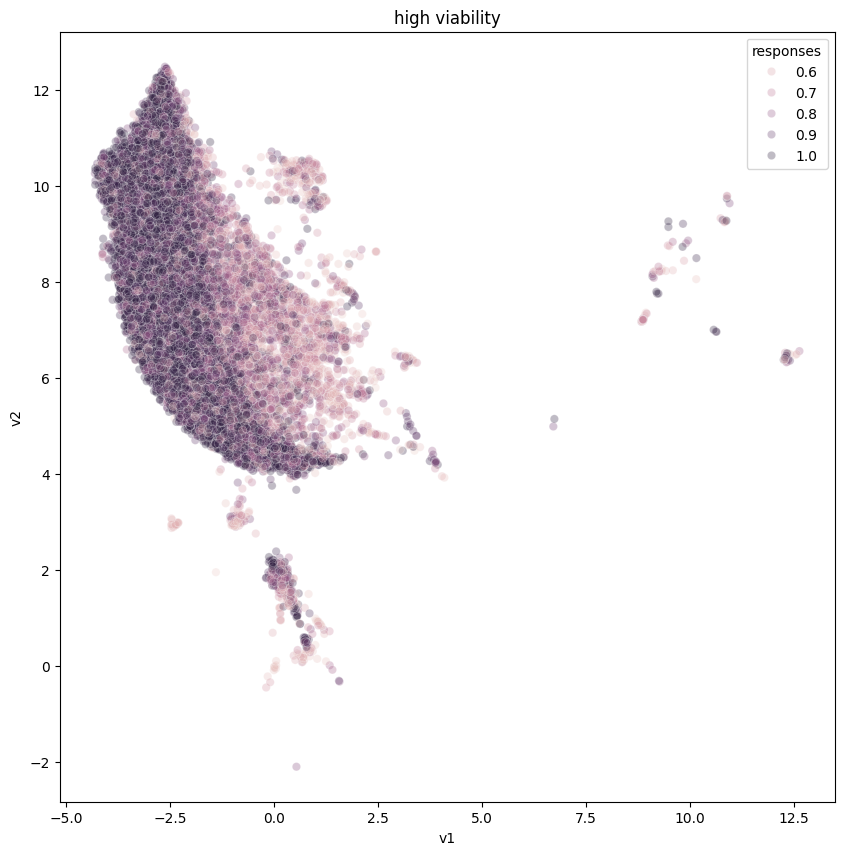

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('high viability')
sns.scatterplot(data=df_umap[df_umap['responses'] >= 0.5], x='v1', y='v2', hue='responses', alpha=0.3)

### Responses low viability

<Axes: title={'center': 'low viability'}, xlabel='v1', ylabel='v2'>

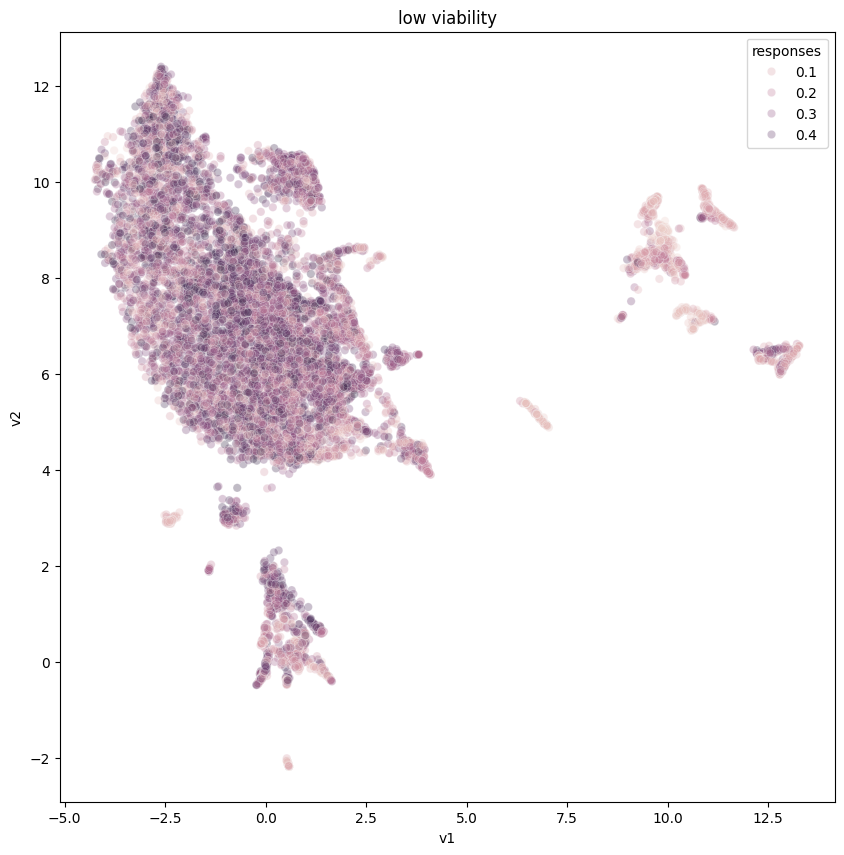

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('low viability')
sns.scatterplot(data=df_umap[df_umap['responses'] < 0.5], x='v1', y='v2', hue='responses', alpha=0.3)

## Cluster content (cell lines)

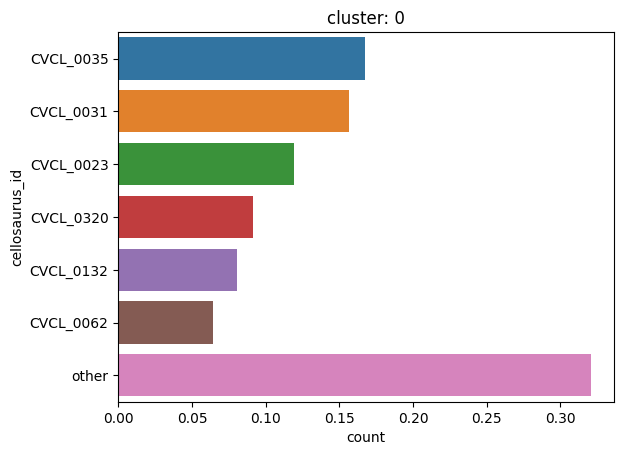

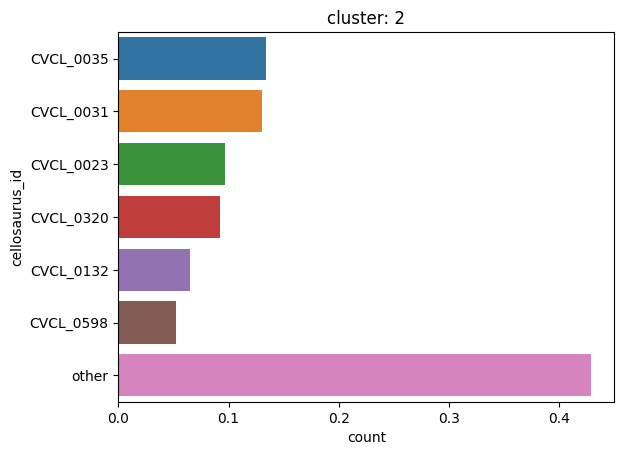

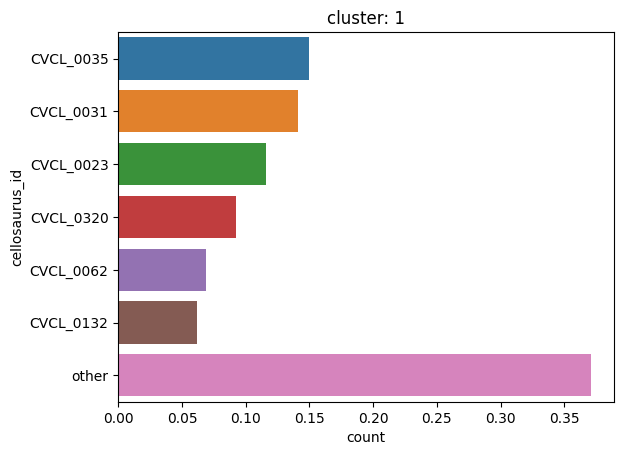

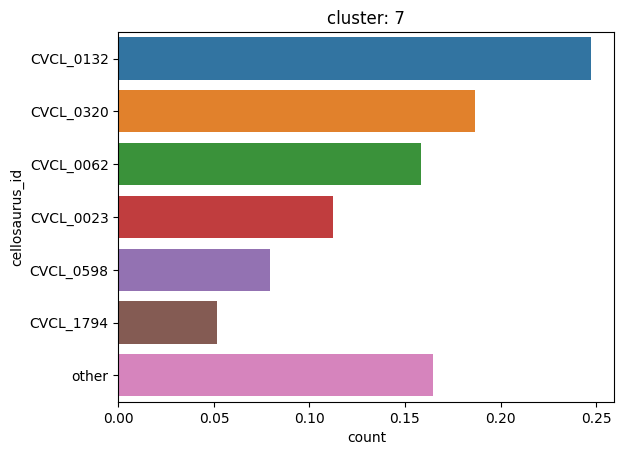

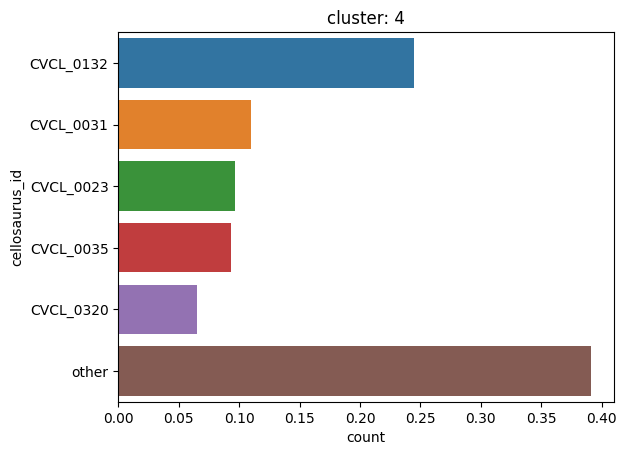

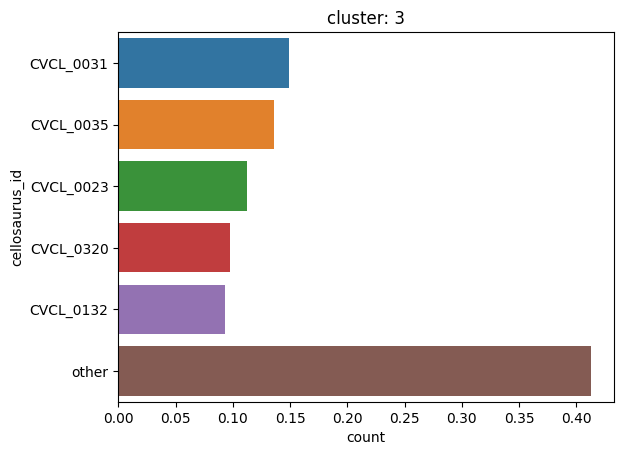

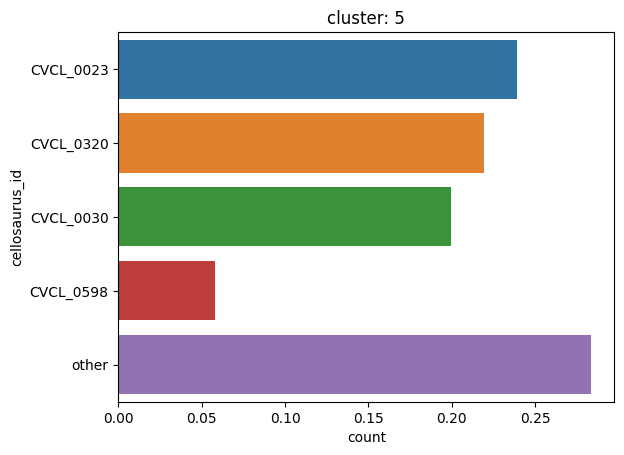

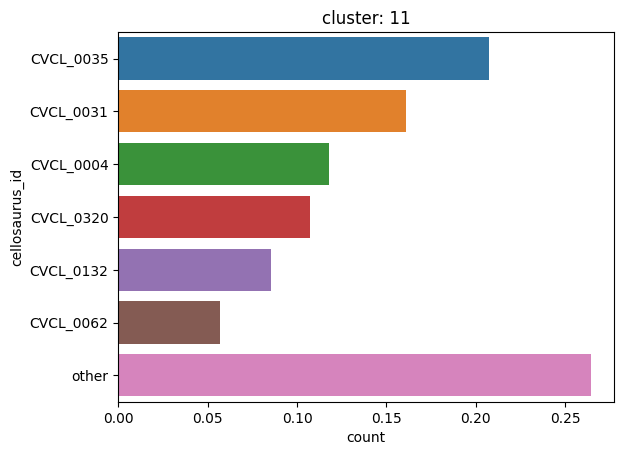

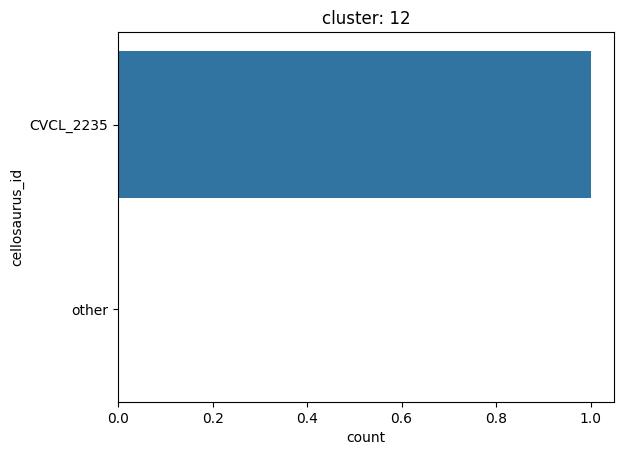

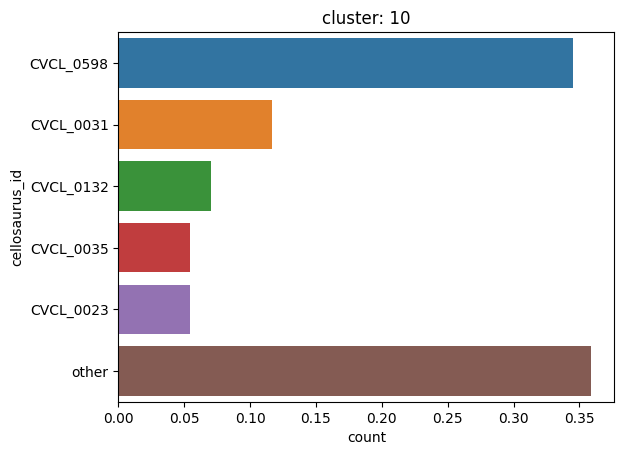

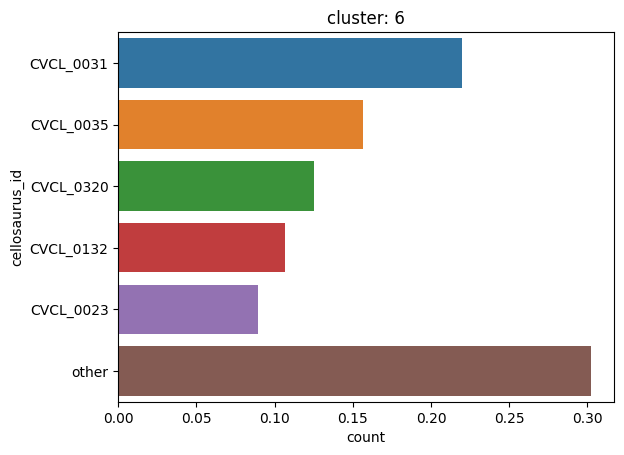

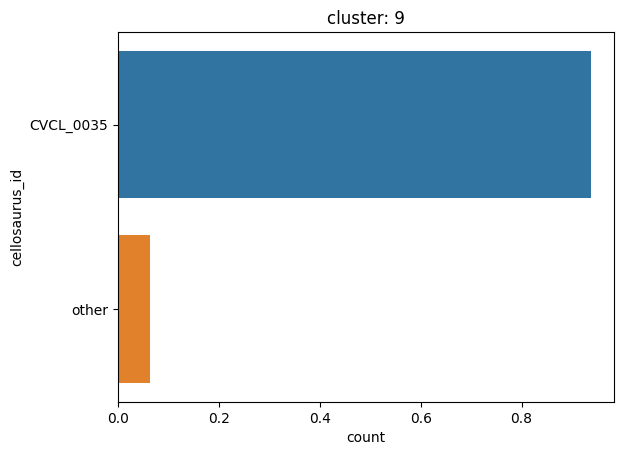

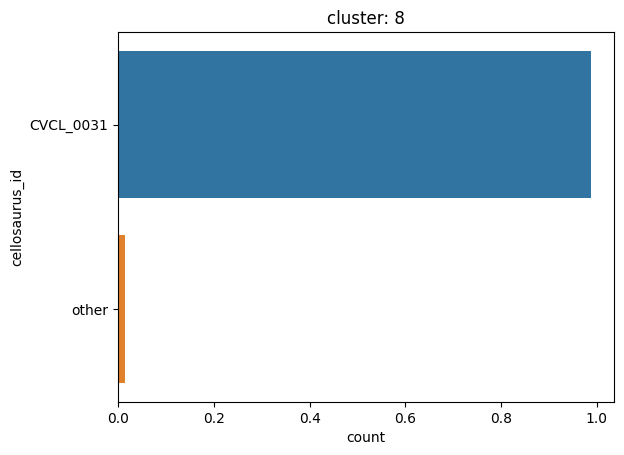

In [36]:
for label in df['leiden'].unique():
    df_ = df[df['leiden'] == label]
    df_ratio = pd.DataFrame(df_['cellosaurus_id'].value_counts()/len(df_)).reset_index()
    df_ratio_ = pd.concat([df_ratio[df_ratio['count'] >= 0.05], pd.DataFrame(['other', df_ratio[df_ratio['count'] < 0.05]['count'].sum()]).T.rename(columns={0: 'cellosaurus_id', 1: 'count'})])
    plt.title('cluster: ' + str(label))
    sns.barplot(df_ratio_, x='count', y='cellosaurus_id', hue='cellosaurus_id', orient='y')
    plt.show()
    #break

## Cluster content (drugs)

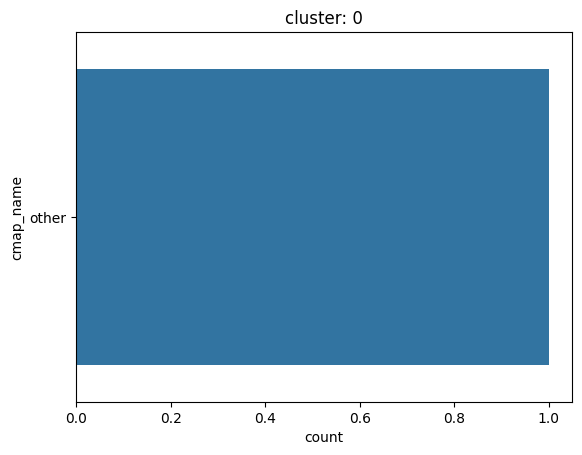

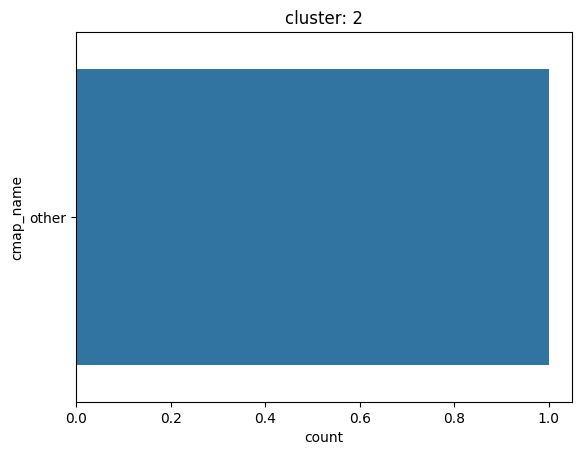

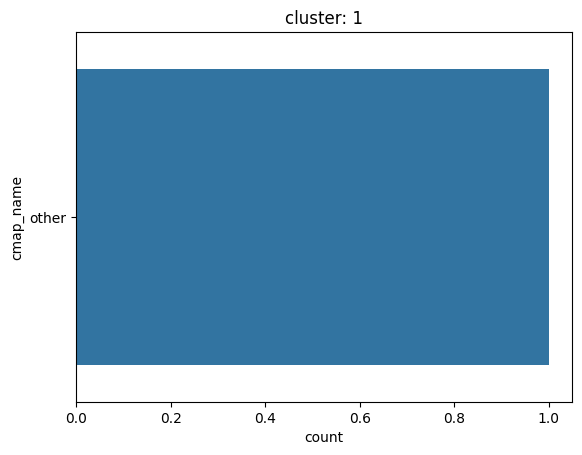

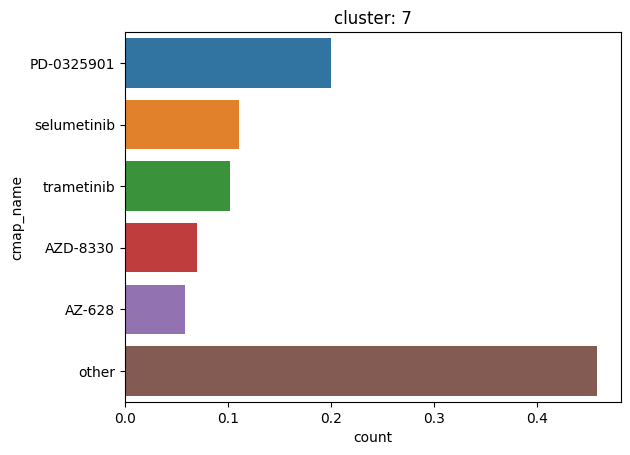

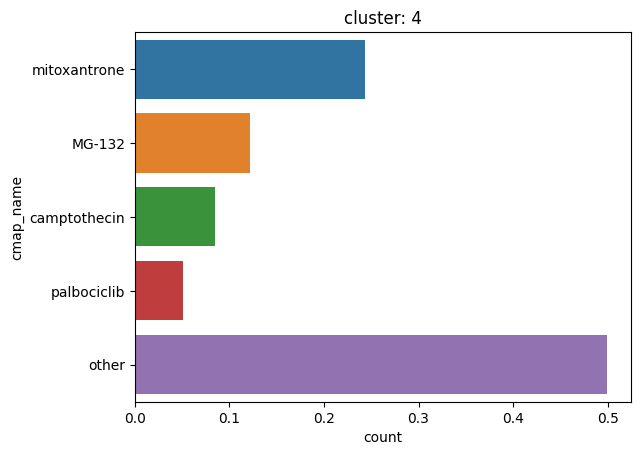

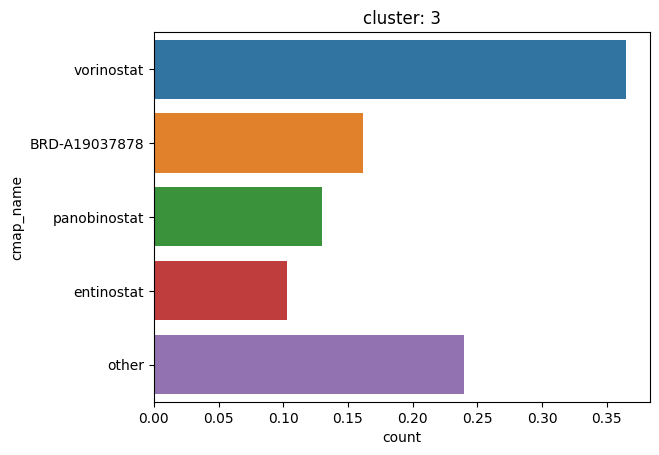

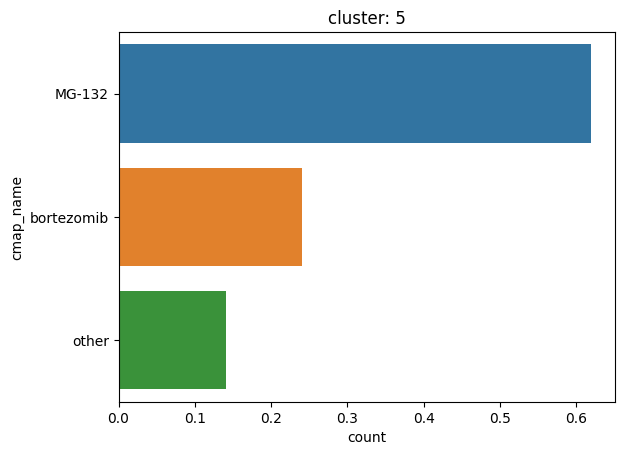

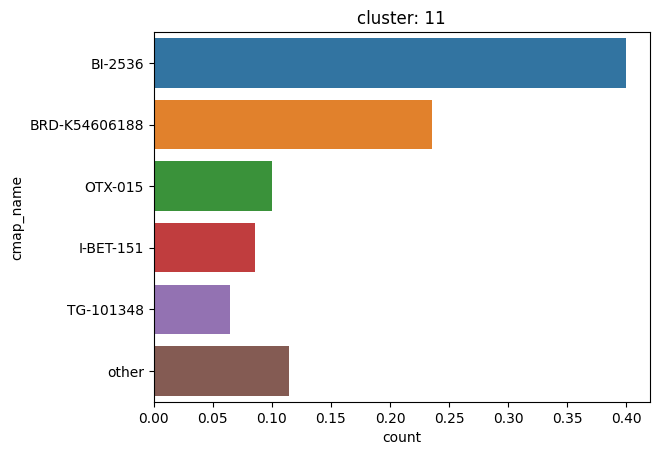

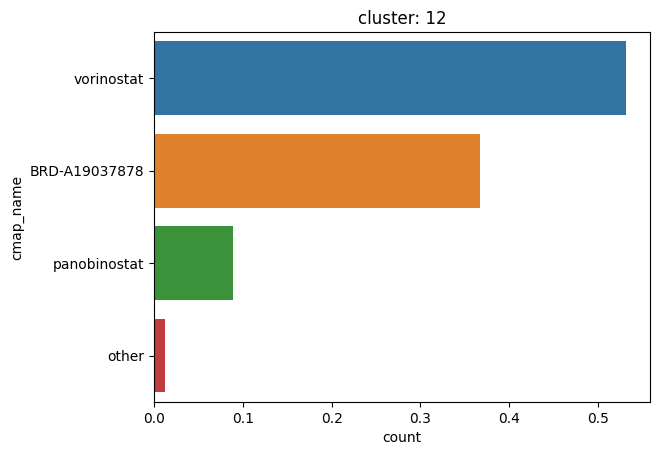

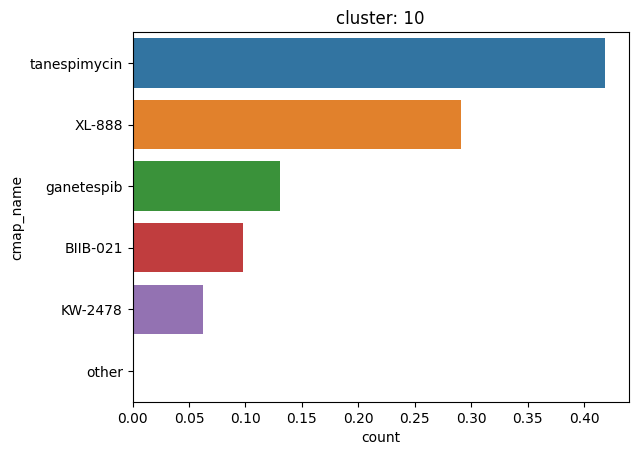

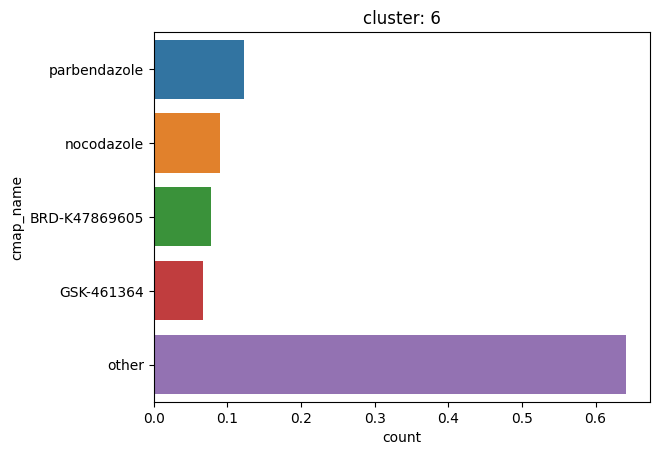

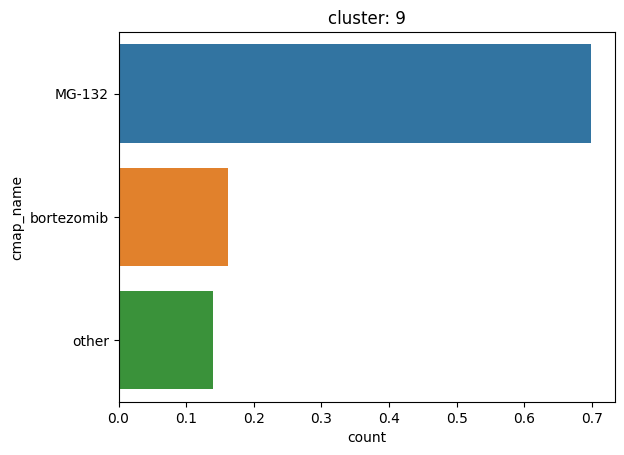

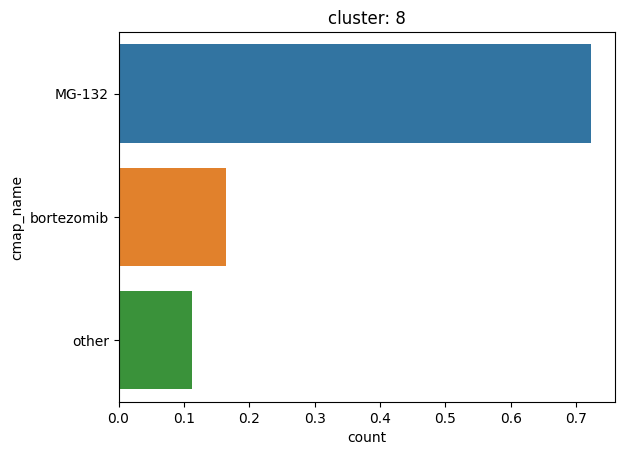

In [37]:
for label in df['leiden'].unique():
    df_ = df[df['leiden'] == label]
    df_ratio = pd.DataFrame(df_['cmap_name'].value_counts()/len(df_)).reset_index()
    df_ratio_ = pd.concat([df_ratio[df_ratio['count'] >= 0.05], pd.DataFrame(['other', df_ratio[df_ratio['count'] < 0.05]['count'].sum()]).T.rename(columns={0: 'cmap_name', 1: 'count'})])
    plt.title('cluster: ' + str(label))
    sns.barplot(df_ratio_, x='count', y='cmap_name', hue='cmap_name', orient='y')
    plt.show()
    #break

## Visualization of gene expression heatmap within one cluster

In [27]:
df_leiden = pd.read_parquet('../../NO_BACKUP/lincs_2020/labels.parquet')

In [28]:
df_leiden

leiden
0           0
1           0
2           0
3           2
4           2
...       ...
40504       2
40505       0
40506       3
40507       1
40508       2

[40509 rows x 1 columns]

In [11]:
df['leiden'] = df_leiden

In [39]:
import numpy as np
from tqdm import tqdm

In [38]:
cols_expr = df.columns[2057:14385]

In [ ]:
for cluster in df['leiden'].unique():
    df_ = df[df['leiden'] == cluster]
    target = np.zeros(len(df_))
    target[df_['responses'].to_numpy() > 0.5] = 1
    colors = ['blue' if item==1 else 'red' for item in target]
    plt.figure(figsize=(14, 14))
    sns.clustermap(df_[cols_expr].values, vmin=-10, vmax=10, cmap='vlag', center=0, row_colors=colors)
    plt.title('cluster:' + str(cluster))
    #plt.savefig('../../NO_BACKUP/lincs_2020/leiden_3.png', dpi=600)
    plt.show()

<Figure size 1400x1400 with 0 Axes>

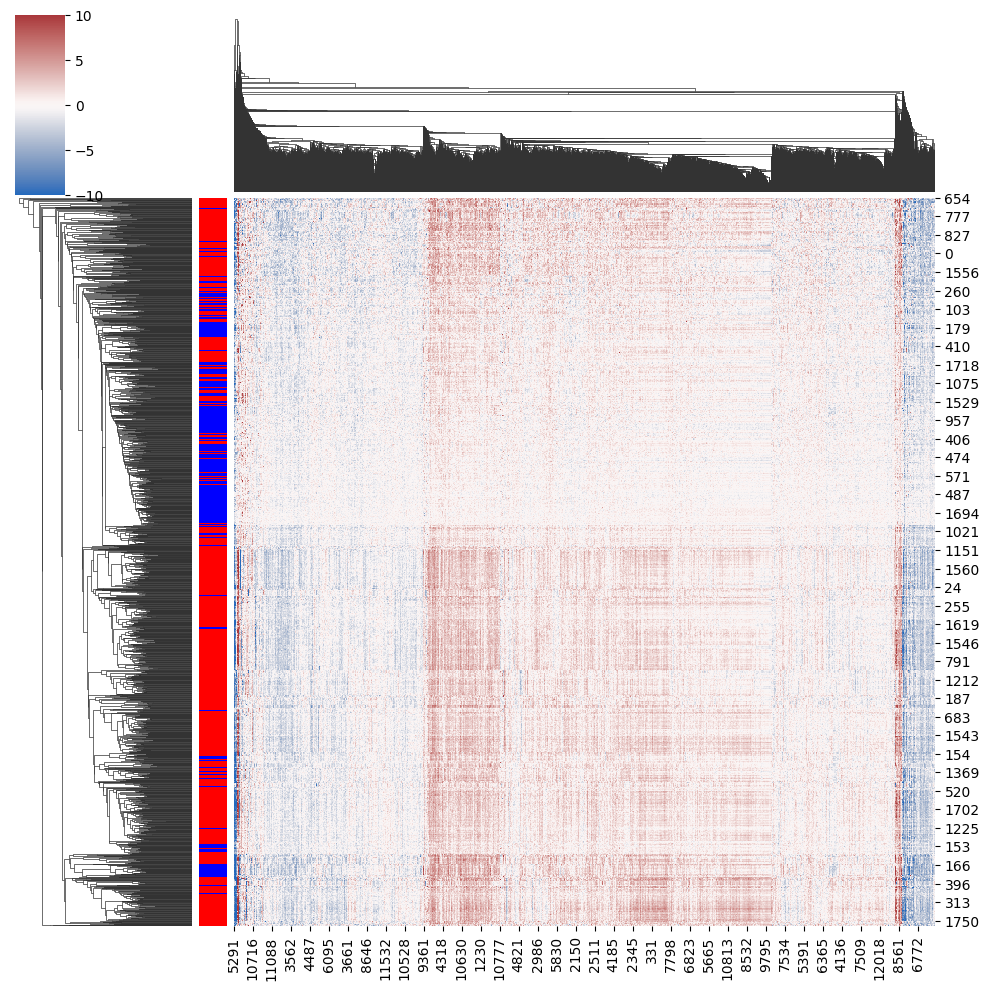

In [17]:
df_ = df[df['leiden'] == 3]
target = np.zeros(len(df_))
target[df_['responses'].to_numpy() > 0.5] = 1
colors = ['blue' if item==1 else 'red' for item in target]
plt.figure(figsize=(14, 14))
sns.clustermap(df_[cols_expr].values, vmin=-10, vmax=10, cmap='vlag', center=0, row_colors=colors)
#plt.savefig('../../NO_BACKUP/lincs_2020/leiden_3.png', dpi=600)
plt.show()